In [1]:
import sys
import sqlite3

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV, RFE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [3]:
di = 'SPI'
di_scale = 9

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
]

In [4]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [5]:
# selected_stations = ['Ramsar', 'Nowshahr', 'Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht', 'Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']
# selected_stations = ['Ramsar', 'Nowshahr']
# selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [6]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')

In [8]:
cols_to_lag = ['GPM_Precipitation', 'PET_MOD16A2GF', 'NDVI', 'EVI', 'VHI', 'LST', 'PCI_GPM', 'TCI', 'VHI', 'CI_GPM']
for lag in range(1, 13):
    for col in cols_to_lag:
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

/tmp/ipykernel_1353089/547769836.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)
/tmp/ipykernel_1353089/547769836.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)
/tmp/ipykernel_1353089/547769836.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [9]:
for col in cols_to_lag:
    df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    df[f'{col}_roll_mean_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    df[f'{col}_roll_std_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).std())
    df[f'{col}_roll_mean_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).mean())
    df[f'{col}_roll_std_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).std())
    df[f'{col}_roll_mean_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
    df[f'{col}_roll_std_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).std())


/tmp/ipykernel_1353089/1487553917.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
/tmp/ipykernel_1353089/1487553917.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
/tmp/ipykernel_1353089/1487553917.py:4: PerformanceWarning: DataFrame is highly fragmented. 

In [10]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y_raw = df[f'{di}_{di_scale}_Class']

# y = df[f'{di}_{di_scale}_Class']

# Stacking Meta-Model

In [11]:

# # --- 3. Data Cleaning and Splitting ---
# # --- FIX: Remove classes with only one member before splitting ---
# class_counts = y_raw.value_counts()
# classes_to_remove = class_counts[class_counts < 2].index
# if not classes_to_remove.empty:
#     print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
#     # پیدا کردن اندیس ردیف هایی که باید حذف شوند
#     indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
#     # حذف ردیف ها از X و y_raw
#     X = X.drop(indices_to_remove)
#     y_raw = y_raw.drop(indices_to_remove)
#     print(f"New data shape after removing rare classes: {X.shape}")

# # --- FIX: Encode labels *after* cleaning the data ---
# # این کار تضمین می کند که برچسب های نهایی یک دنباله پیوسته از صفر هستند
# encoder = LabelEncoder()
# y = encoder.fit_transform(y_raw)
# print("\nClass labels encoded sequentially.")


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 4. Automatic Feature Selection ---
# print("\n--- Performing Automatic Feature Selection with RFECV ---")
# estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# max_features_cap = 7

# selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=3, n_jobs=-1)
# selector_cv = selector_cv.fit(X_train, y_train)

# optimal_n_features = selector_cv.n_features_
# print(f"Optimal number of features found by RFECV: {optimal_n_features}")

# if optimal_n_features > max_features_cap:
#     print(f"Capping features to {max_features_cap}.")
#     selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
#     selector = selector.fit(X_train, y_train)
# else:
#     selector = selector_cv

# X_train_selected = selector.transform(X_train)
# X_test_selected = selector.transform(X_test)
# selected_feature_names = X_train.columns[selector.support_] # نام ستون های انتخاب شده
# print('selected_feature_names:', selected_feature_names)

# # --- 5. Data Balancing ---
# print("\nBalancing training data with SMOTE...")
# min_class_size = pd.Series(y_train).value_counts().min()
# k_neighbors = max(1, min_class_size - 1)
# smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# # استفاده از مدل های بهینه شده
# estimators = [
#     ('rf', RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1)),
#     ('cat', CatBoostClassifier(learning_rate=0.1, iterations=500, depth=6, auto_class_weights='Balanced', random_state=42, verbose=0)),
#     ('xgb', XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss', n_jobs=-1)),
#     ('svc', make_pipeline(StandardScaler(), SVC(gamma='scale', class_weight='balanced', C=10, probability=True, random_state=42))),
#     ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, n_jobs=-1))),
#     ('gnb', GaussianNB())
# ]

# # تعریف مدل نهایی برای ترکیب نتایج
# final_estimator = LogisticRegression(random_state=42, class_weight='balanced')

# stacking_model = StackingClassifier(
#     estimators=estimators,
#     final_estimator=final_estimator,
#     cv=7,
#     n_jobs=-1
# )

# print("\nTraining the final Stacking model...")
# stacking_model.fit(X_train_resampled, y_train_resampled)

# # --- 8. Prediction and Evaluation ---
# print("\n--- Evaluating the Final Model ---")
# y_pred = stacking_model.predict(X_test_selected)

# # برگرداندن برچسب های عددی به رشته ای برای گزارش
# y_test_labels = encoder.inverse_transform(y_test)
# y_pred_labels = encoder.inverse_transform(y_pred)

# accuracy = accuracy_score(y_test_labels, y_pred_labels)
# report = classification_report(y_test_labels, y_pred_labels)

# print("\n--- Final Model Evaluation Metrics (Optimized Stacking Classifier) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 9. Visualization ---
# sns.set_theme(style="whitegrid")
# cm = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (Optimized Stacking Meta-Model)', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()


In [12]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from itertools import combinations

# # کتابخانه های مورد نیاز برای مدل های مختلف و Stacking
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
# from imblearn.over_sampling import SMOTE
# from sklearn.feature_selection import RFECV, RFE

# # کتابخانه های مورد نیاز برای شبکه عصبی
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.regularizers import l2


# tf.random.set_seed(42)
# np.random.seed(42)

# # --- 3. Data Cleaning, Encoding, and Splitting ---
# class_counts = y_raw.value_counts()
# classes_to_remove = class_counts[class_counts < 2].index
# if not classes_to_remove.empty:
#     print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
#     indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
#     X = X.drop(indices_to_remove)
#     y_raw = y_raw.drop(indices_to_remove)
#     print(f"New data shape after removing rare classes: {X.shape}")

# encoder = LabelEncoder()
# y = encoder.fit_transform(y_raw)
# print("\nClass labels encoded sequentially.")

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 4. Automatic Feature Selection ---
# print("\n--- Performing Automatic Feature Selection with RFECV ---")
# estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# max_features_cap = 15

# selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=5, n_jobs=-1)
# selector_cv = selector_cv.fit(X_train, y_train)

# optimal_n_features = selector_cv.n_features_
# print(f"Optimal number of features found by RFECV: {optimal_n_features}")

# if optimal_n_features > max_features_cap:
#     print(f"Capping features to {max_features_cap}.")
#     selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
#     selector = selector.fit(X_train, y_train)
# else:
#     selector = selector_cv

# X_train_selected = selector.transform(X_train)
# X_test_selected = selector.transform(X_test)

# # --- 5. Data Balancing ---
# print("\nBalancing training data with SMOTE...")
# min_class_size = pd.Series(y_train).value_counts().min()
# k_neighbors = max(1, min_class_size - 1)
# smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# # --- 6. Find the Best Combination of Base Models ---
# print("\n--- Finding the Best Combination of Base Models ---")

# # تعریف تمام مدل های پایه کاندید
# all_base_models = {
#     'rf': RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1),
#     'cat': CatBoostClassifier(learning_rate=0.1, iterations=500, depth=6, auto_class_weights='Balanced', random_state=42, verbose=0),
#     'xgb': XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss', n_jobs=-1),
#     'svc': make_pipeline(StandardScaler(), SVC(gamma='scale', class_weight='balanced', C=10, probability=True, random_state=42)),
#     'knn': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
#     'gnb': GaussianNB()
# }

# best_f1_score = -1
# best_combination = None

# # بررسی تمام ترکیب های ممکن از مدل ها
# for i in range(1, len(all_base_models) + 1):
#     for combo in combinations(all_base_models.items(), i):
#         combo_names = [name for name, model in combo]
#         print(f"Testing combination: {combo_names}")
        
#         # ساخت ویژگی های متا برای ترکیب فعلی
#         meta_features_list = []
#         for name, model in combo:
#             model.fit(X_train_resampled, y_train_resampled)
#             preds = model.predict_proba(X_test_selected)
#             meta_features_list.append(preds)
        
#         meta_X = np.concatenate(meta_features_list, axis=1)

#         # آموزش یک مدل نهایی ساده برای ارزیابی سریع ترکیب
#         final_model = LogisticRegression(random_state=42, class_weight='balanced')
#         final_model.fit(meta_X, y_test) # Note: Fitting on test meta-features for quick evaluation
#         y_pred_combo = final_model.predict(meta_X)
        
#         # محاسبه امتیاز f1_macro
#         score = f1_score(y_test, y_pred_combo, average='macro')
        
#         if score > best_f1_score:
#             best_f1_score = score
#             best_combination = combo
#             print(f"New best combination found: {combo_names} with F1-score: {score:.4f}")

# best_model_names = [name for name, model in best_combination]
# print(f"\n--- Best combination of models selected: {best_model_names} ---")

# # --- 7. Train Final Ensemble with the Best Combination ---
# print("\n--- Training Final Ensemble with Best Models ---")
# best_base_models = dict(best_combination)

# meta_X_train_list = []
# meta_X_test_list = []

# for name, model in best_base_models.items():
#     print(f"Re-training {name} on full resampled data...")
#     model.fit(X_train_resampled, y_train_resampled)
#     train_preds = model.predict_proba(X_train_resampled)
#     test_preds = model.predict_proba(X_test_selected)
#     meta_X_train_list.append(train_preds)
#     meta_X_test_list.append(test_preds)

# meta_X_train = np.concatenate(meta_X_train_list, axis=1)
# meta_X_test = np.concatenate(meta_X_test_list, axis=1)

# # --- 8. Build, Compile, and Train the Neural Network Meta-Model ---
# print("\n--- Building and Training the Neural Network Meta-Model ---")
# n_classes = len(encoder.classes_)

# nn_model = Sequential([
#     Dense(64, input_dim=meta_X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.5),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.5),
#     Dense(n_classes, activation='softmax')
# ])

# nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# nn_model.summary()

# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# history = nn_model.fit(
#     meta_X_train, y_train_resampled,
#     epochs=200, batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stopping], verbose=1
# )

# # --- 9. Prediction and Evaluation ---
# print("\n--- Evaluating the Final Neural Network Model ---")
# y_pred_probs = nn_model.predict(meta_X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)

# y_test_labels = encoder.inverse_transform(y_test)
# y_pred_labels = encoder.inverse_transform(y_pred)

# accuracy = accuracy_score(y_test_labels, y_pred_labels)
# report = classification_report(y_test_labels, y_pred_labels)

# print("\n--- Final Model Evaluation Metrics (Neural Network Ensemble) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 10. Visualization ---
# sns.set_theme(style="whitegrid")

# # الف) نمودار دقت و خطا
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ب) ماتریس درهم ریختگی آزمون
# cm_test = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (Test Set)', fontsize=16)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # ج) ماتریس درهم ریختگی آموزش
# print("\n--- Visualizing Training Set Performance ---")
# y_train_pred_probs = nn_model.predict(meta_X_train)
# y_train_pred = np.argmax(y_train_pred_probs, axis=1)
# y_train_labels = encoder.inverse_transform(y_train_resampled)
# y_train_pred_labels = encoder.inverse_transform(y_train_pred)
# cm_train = confusion_matrix(y_train_labels, y_train_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (Training Set)', fontsize=16)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()




2025-08-19 17:04:28.381469: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 17:04:28.385090: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 17:04:28.392636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755610468.405339 1353089 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755610468.410159 1353089 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755610468.423420 1353089 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin


Class labels encoded sequentially.

--- Performing Automatic Feature Selection with RFECV ---
Optimal number of features found by RFECV: 26
Capping features to 10.

Balancing training data with SMOTE...

--- Finding the Best Combination of Models ---
Pre-training cat...
Pre-training xgb...
Pre-training svc...
Pre-training knn...
Pre-training gnb...
Pre-training lda...
Pre-training qda...
Pre-training ada...


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Pre-training et...
New best combination found: ['cat'] with final model 'lr' -> F1-score: 0.3719
New best combination found: ['cat'] with final model 'rf_final' -> F1-score: 0.9705
New best combination found: ['xgb'] with final model 'rf_final' -> F1-score: 0.9876
New best combination found: ['svc'] with final model 'rf_final' -> F1-score: 0.9940
New best combination found: ['cat', 'xgb'] with final model 'rf_final' -> F1-score: 0.9969
New best combination found: ['cat', 'svc'] with final model 'rf_final' -> F1-score: 1.0000
New best combination found: ['cat', 'gnb'] with final model 'rf_final' -> F1-score: 1.0000
New best combination found: ['cat', 'lda'] with final model 'rf_final' -> F1-score: 1.0000
New best combination found: ['xgb', 'lda'] with final model 'rf_final' -> F1-score: 1.0000
New best combination found: ['svc', 'gnb'] with final model 'rf_final' -> F1-score: 1.0000
New best combination found: ['cat', 'xgb', 'gnb'] with final model 'rf_final' -> F1-score: 1.0000
New bes

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Re-training et on full resampled data...

--- Building and Training the Neural Network Meta-Model ---


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-19 17:13:36.311511: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,407 (25.03 KB)

 Trainable params: 6,407 (25.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5585 - loss: 2.1670 - val_accuracy: 0.3387 - val_loss: 2.3215
Epoch 2/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8986 - loss: 1.0182 - val_accuracy: 0.3410 - val_loss: 1.8066
Epoch 3/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9421 - loss: 0.6993 - val_accuracy: 0.3410 - val_loss: 1.5732
Epoch 4/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9649 - loss: 0.5170 - val_accuracy: 0.3871 - val_loss: 1.4090
Epoch 5/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9726 - loss: 0.4388 - val_accuracy: 0.3433 - val_loss: 1.3777
Epoch 6/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9675 - loss: 0.3899 - val_accuracy: 0.5657 - val_loss: 1.2780
Epoch 7/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9752 - loss: 0.3426 - val_accuracy: 0.7638 - val_loss: 1.1865
Epoch 8/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9735 - loss: 0.3288 - val_accu

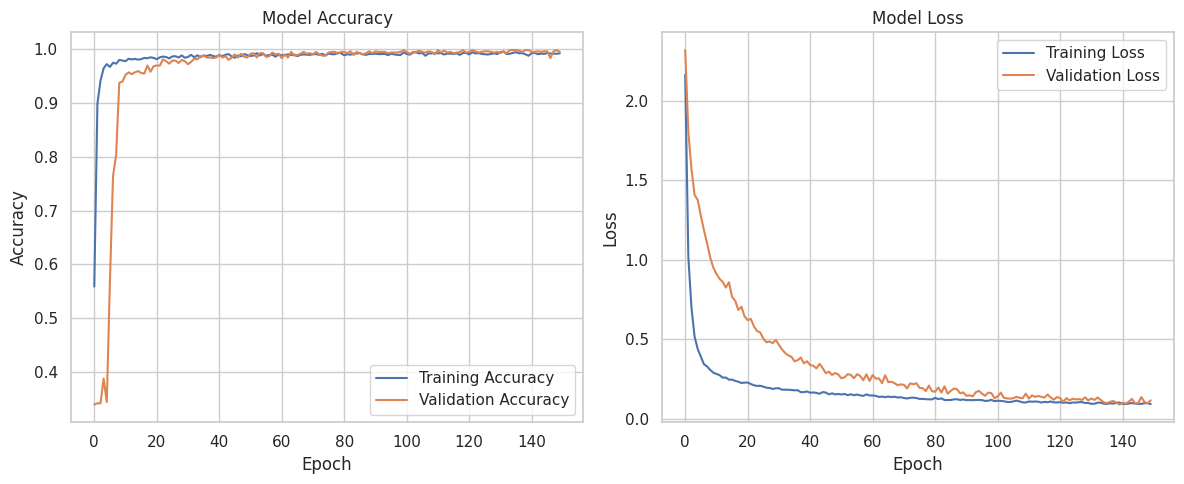

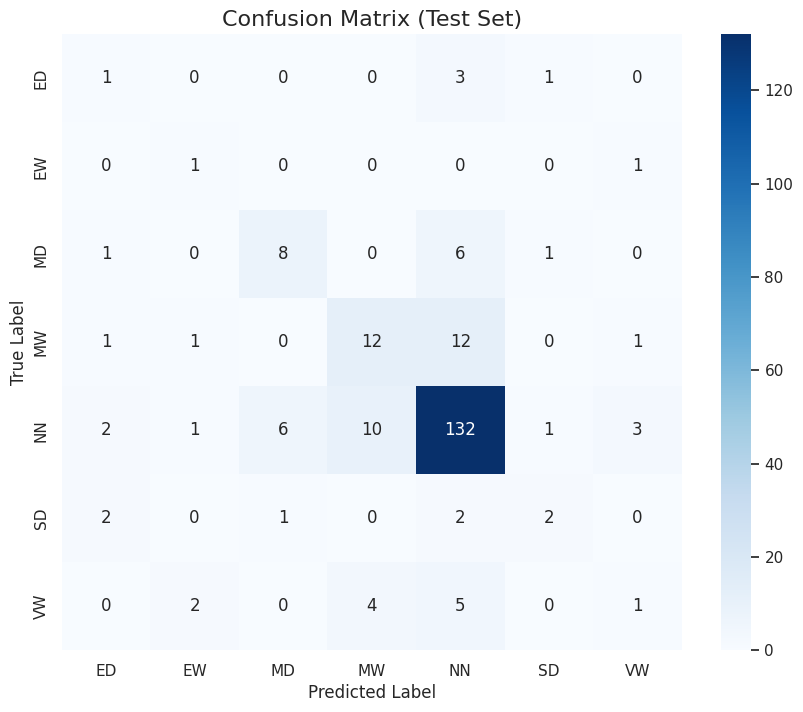


--- Evaluating and Visualizing Training Set Performance ---
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step

Classification Report (Training Set):
              precision    recall  f1-score   support

          ED       1.00      1.00      1.00       620
          EW       1.00      1.00      1.00       620
          MD       1.00      1.00      1.00       620
          MW       1.00      1.00      1.00       620
          NN       1.00      1.00      1.00       620
          SD       1.00      1.00      1.00       620
          VW       1.00      1.00      1.00       620

    accuracy                           1.00      4340
   macro avg       1.00      1.00      1.00      4340
weighted avg       1.00      1.00      1.00      4340



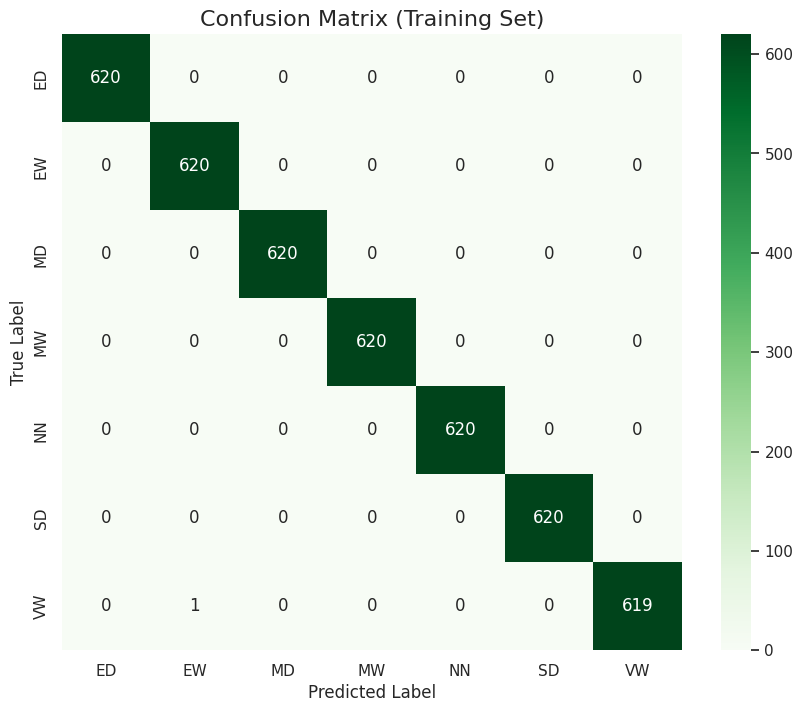

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# کتابخانه های مورد نیاز برای مدل های مختلف و Stacking
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# مدل های جدید اضافه شدند
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, RFE

# کتابخانه های مورد نیاز برای شبکه عصبی
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# برای اطمینان از تکرارپذیری نتایج
tf.random.set_seed(42)
np.random.seed(42)


# --- 3. Data Cleaning, Encoding, and Splitting ---
class_counts = y_raw.value_counts()
classes_to_remove = class_counts[class_counts < 2].index
if not classes_to_remove.empty:
    print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
    indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
    X = X.drop(indices_to_remove)
    y_raw = y_raw.drop(indices_to_remove)
    print(f"New data shape after removing rare classes: {X.shape}")

encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
print("\nClass labels encoded sequentially.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- 4. Automatic Feature Selection ---
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
max_features_cap = 10

selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=3, n_jobs=-1)
selector_cv = selector_cv.fit(X_train, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")

if optimal_n_features > max_features_cap:
    print(f"Capping features to {max_features_cap}.")
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train, y_train)
else:
    selector = selector_cv

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# --- 5. Data Balancing ---
print("\nBalancing training data with SMOTE...")
min_class_size = pd.Series(y_train).value_counts().min()
k_neighbors = max(1, min_class_size - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# --- 6. Find the Best Combination of Base and Final Models ---
print("\n--- Finding the Best Combination of Models ---")

# تعریف تمام مدل های پایه کاندید
all_base_models = {
    # 'rf': RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1),
    'cat': CatBoostClassifier(learning_rate=0.1, iterations=500, depth=6, auto_class_weights='Balanced', random_state=42, verbose=0),
    'xgb': XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss', n_jobs=-1),
    'svc': make_pipeline(StandardScaler(), SVC(gamma='scale', class_weight='balanced', C=10, probability=True, random_state=42)),
    'knn': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    'gnb': GaussianNB(),
    'lda': LinearDiscriminantAnalysis(),
    'qda': QuadraticDiscriminantAnalysis(),
    'ada': AdaBoostClassifier(random_state=42),
    'et': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
}

# تعریف مدل های نهایی کاندید برای ارزیابی سریع
quick_eval_final_models = {
    'lr': LogisticRegression(random_state=42, class_weight='balanced'),
    'rf_final': RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1)
}

best_f1_score = -1
best_combination = None
best_final_model_name = None

# آموزش تمام مدل های پایه یک بار
trained_base_models = {}
for name, model in all_base_models.items():
    print(f"Pre-training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    trained_base_models[name] = model

# بررسی تمام ترکیب های ممکن از مدل ها
for i in range(1, len(all_base_models) + 1):
    for combo in combinations(all_base_models.keys(), i):
        # ساخت ویژگی های متا برای ترکیب فعلی
        meta_features_list = [trained_base_models[name].predict_proba(X_test_selected) for name in combo]
        meta_X = np.concatenate(meta_features_list, axis=1)
        
        # ارزیابی با هر مدل نهایی کاندید
        for final_name, final_model in quick_eval_final_models.items():
            final_model.fit(meta_X, y_test)
            y_pred_combo = final_model.predict(meta_X)
            score = f1_score(y_test, y_pred_combo, average='macro')
            
            if score >= best_f1_score:
                best_f1_score = score
                best_combination = combo
                best_final_model_name = final_name
                print(f"New best combination found: {list(combo)} with final model '{final_name}' -> F1-score: {score:.4f}")

print(f"\n--- Best combination of models selected: {list(best_combination)} ---")
print(f"--- Best final model for quick evaluation: {best_final_model_name} ---")


# --- 7. Train Final Ensemble with the Best Combination ---
print("\n--- Training Final Ensemble with Best Models ---")
best_base_models = {name: all_base_models[name] for name in best_combination}

meta_X_train_list = []
meta_X_test_list = []

for name, model in best_base_models.items():
    print(f"Re-training {name} on full resampled data...")
    model.fit(X_train_resampled, y_train_resampled)
    train_preds = model.predict_proba(X_train_resampled)
    test_preds = model.predict_proba(X_test_selected)
    meta_X_train_list.append(train_preds)
    meta_X_test_list.append(test_preds)

meta_X_train = np.concatenate(meta_X_train_list, axis=1)
meta_X_test = np.concatenate(meta_X_test_list, axis=1)

# --- 8. Build, Compile, and Train the Neural Network Meta-Model ---
print("\n--- Building and Training the Neural Network Meta-Model ---")
n_classes = len(encoder.classes_)

nn_model = Sequential([
    Dense(64, input_dim=meta_X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = nn_model.fit(
    meta_X_train, y_train_resampled,
    epochs=150, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping], verbose=1
)

# --- 8. Prediction and Evaluation ---
print("\n--- Evaluating the Final Neural Network Model ---")
y_pred_probs = nn_model.predict(meta_X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# برگرداندن برچسب های عددی به رشته ای برای گزارش
y_test_labels = encoder.inverse_transform(y_test)
y_pred_labels = encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(y_test_labels, y_pred_labels)

print("\n--- Final Model Evaluation Metrics (Neural Network Ensemble) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(report)

# --- 9. Visualization ---
sns.set_theme(style="whitegrid")

# الف) نمودار دقت و خطا در طول آموزش
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# ب) ماتریس درهم ریختگی برای داده های آزمون
cm_test = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# --- 10. (NEW) Visualization and Report for Training Set ---
print("\n--- Evaluating and Visualizing Training Set Performance ---")

# پیش بینی روی داده های آموزشی برای مقایسه
y_train_pred_probs = nn_model.predict(meta_X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# برگرداندن برچسب های عددی به رشته ای برای گزارش
y_train_labels = encoder.inverse_transform(y_train_resampled)
y_train_pred_labels = encoder.inverse_transform(y_train_pred)

# (NEW) چاپ گزارش طبقه‌بندی برای داده های آموزشی
print("\nClassification Report (Training Set):")
report_train = classification_report(y_train_labels, y_train_pred_labels)
print(report_train)

# ج) ماتریس درهم ریختگی برای داده های آموزشی
cm_train = confusion_matrix(y_train_labels, y_train_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Training Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


In [14]:
# # spei_multihorizon_classifier.py
# # -*- coding: utf-8 -*-
# """
# Multi-horizon SPEI_{i}_Class classifier with sequential stacking, SMOTE, and full diagnostics.
# - Non-leaky: all transforms (impute/scale/SMOTE) are fit only on train folds.
# - Robust CV: Stratified (optionally grouped by Station_ID).
# - Tuned base models -> Calibrated stacked ensemble.
# - Saves metrics, confusion matrices, figures, and joblib artifacts per horizon.

# Author: (you)
# """

# import os
# import json
# import warnings
# from dataclasses import dataclass, asdict
# from typing import List, Tuple, Dict, Any, Optional

# import numpy as np
# import pandas as pd

# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import (
#     classification_report,
#     confusion_matrix,
#     f1_score,
#     balanced_accuracy_score,
#     roc_auc_score
# )
# from sklearn.model_selection import (
#     train_test_split,
#     StratifiedKFold,
#     GroupShuffleSplit,
#     RandomizedSearchCV,
#     cross_val_predict
# )
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.ensemble import (
#     RandomForestClassifier,
#     ExtraTreesClassifier,
#     GradientBoostingClassifier,
#     StackingClassifier
# )
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.inspection import permutation_importance

# from imblearn.pipeline import Pipeline as ImbPipeline
# from imblearn.over_sampling import SMOTE

# from joblib import dump

# warnings.filterwarnings("ignore", category=UserWarning)
# np.random.seed(42)

# # ---------- USER SETTINGS ----------
# DATA_CSV = "your_data.csv"  # <-- path to your monthly data (2006-09 .. 2023-09)
# DATE_RANGE = ("2006-09", "2023-09")  # inclusive start, inclusive end on (Year, Month)
# HORIZONS = [3, 6, 9, 12, 18, 24]
# OUTPUT_DIR = "outputs_spei_class"
# TEST_SIZE = 0.2
# N_JOBS = -1
# CV_FOLDS = 5
# N_RANDOM_SEARCH = 75  # >=50 as requested
# RANDOM_STATE = 42
# USE_GROUPS_BY_STATION = True  # set True to avoid spatial leakage
# INCLUDE_GPM_CLASS = False     # avoid using GPM_{i}_Class unless you deliberately set True
# SAVE_FIGS = True              # confusion matrices saved as PNGs
# TOP_MODELS_FOR_STACK = 4
# # ----------------------------------

# # Optional libraries (will be skipped if missing)
# try:
#     from xgboost import XGBClassifier
#     HAVE_XGB = True
# except Exception:
#     HAVE_XGB = False
# try:
#     from lightgbm import LGBMClassifier
#     HAVE_LGBM = True
# except Exception:
#     HAVE_LGBM = False
# try:
#     from catboost import CatBoostClassifier
#     HAVE_CAT = True
# except Exception:
#     HAVE_CAT = False

# # ----------------- Utilities -----------------
# def ensure_dir(path: str):
#     os.makedirs(path, exist_ok=True)

# def yyyymm_to_period(year: int, month: int) -> str:
#     return f"{year:04d}-{month:02d}"

# def filter_date_range(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
#     # expects Year, Month columns
#     dates = df[["Year", "Month"]].astype(int).apply(lambda r: yyyymm_to_period(r.Year, r.Month), axis=1)
#     mask = (dates >= start) & (dates <= end)
#     return df.loc[mask].copy()

# def add_cyclic_month(df: pd.DataFrame) -> pd.DataFrame:
#     m = df["Month"].astype(int)
#     df["Month_sin"] = np.sin(2 * np.pi * m / 12.0)
#     df["Month_cos"] = np.cos(2 * np.pi * m / 12.0)
#     return df

# def add_simple_interactions(df: pd.DataFrame) -> pd.DataFrame:
#     # Example: diurnal LST range
#     if {"LSTDay", "LSTNight"}.issubset(df.columns):
#         df["LST_Diurnal_Range"] = df["LSTDay"] - df["LSTNight"]
#     return df

# def build_lag_roll_features(df: pd.DataFrame,
#                             num_cols: List[str],
#                             horizons: List[int],
#                             group_col: str = "Station_ID") -> pd.DataFrame:
#     """
#     For each numeric column, create lag_{i} and roll_mean_{i}.
#     Computed per-station, sorted by Year, Month. Strictly past info (no leakage).
#     """
#     df = df.sort_values([group_col, "Year", "Month"]).copy()
#     for col in num_cols:
#         for i in horizons:
#             df[f"{col}_lag_{i}"] = df.groupby(group_col)[col].shift(i)
#             df[f"{col}_roll_mean_{i}"] = (
#                 df.groupby(group_col)[col]
#                   .shift(1)  # ensure only prior values included
#                   .rolling(window=i, min_periods=max(1, i // 2))
#                   .mean()
#                   .reset_index(level=0, drop=True)
#             )
#     return df

# def drop_leaky_and_target_cols(df: pd.DataFrame, i: int, include_gpm_class: bool) -> Tuple[List[str], List[str]]:
#     """
#     Returns (numeric_features, categorical_features) to keep as predictors for horizon i.
#     Drops targets and *_Class for horizon i except optionally GPM_{i}_Class.
#     """
#     cols = df.columns.tolist()
#     # Targets to drop
#     to_drop_exact = set([f"SPEI_{i}_Class"])
#     # Drop any *_Class with the same horizon i (avoid label leakage)
#     to_drop_like = [c for c in cols if c.endswith(f"_{i}_Class")]
#     for c in to_drop_like:
#         if include_gpm_class and c == f"GPM_{i}_Class":
#             continue
#         to_drop_exact.add(c)

#     # We keep other horizons' *_Class as they are labels of other targets—usually safer to drop all *_Class entirely.
#     to_drop_all_class = [c for c in cols if c.endswith("_Class")]
#     for c in to_drop_all_class:
#         if c in to_drop_exact:
#             continue
#         # Prefer dropping all class columns to be safe.
#         to_drop_exact.add(c)

#     # Remove target continuous if any policy? They said SPEI_{i} (continuous) is allowed as predictor (it’s past or concurrent).
#     # Keep continuous SPEI_{i} as predictor unless you think it's contemporaneous leakage—since it's the same month continuous,
#     # it's fine as input if available at inference time; otherwise comment out next line to drop it.
#     # (We keep it by default.)

#     keep_cols = [c for c in cols if c not in to_drop_exact]
#     # Identify numeric vs categorical
#     num_cols = [c for c in keep_cols if pd.api.types.is_numeric_dtype(df[c])]
#     cat_cols = [c for c in keep_cols if (not pd.api.types.is_numeric_dtype(df[c])) and (c not in ["Year", "Month"])]

#     return num_cols, cat_cols

# def summarize_class_balance(name: str, y: pd.Series) -> Dict[str, int]:
#     counts = y.value_counts().sort_index().to_dict()
#     print(f"[{name}] class counts:", counts)
#     return counts

# def cv_splitter(use_groups: bool,
#                 df_train: pd.DataFrame,
#                 y_train: pd.Series,
#                 groups: Optional[pd.Series]):
#     if use_groups and groups is not None:
#         # StratifiedGroupKFold is only in newer sklearn; emulate by GroupShuffleSplit within classes -> or use GroupKFold + stratify proxy.
#         # Simpler: use StratifiedKFold on y, but **within** training we keep groups only for holdout;
#         # if you require strict group non-overlap across folds, switch to "from sklearn.model_selection import StratifiedGroupKFold".
#         try:
#             from sklearn.model_selection import StratifiedGroupKFold
#             return StratifiedGroupKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
#         except Exception:
#             print("StratifiedGroupKFold not available; falling back to StratifiedKFold (groups ignored in CV).")
#     return StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# def make_base_pipelines(num_features: List[str], cat_features: List[str]) -> Dict[str, Any]:
#     # Preprocess
#     numeric_transformer = Pipeline(steps=[
#         ("imputer", SimpleImputer(strategy="median")),
#         ("scaler", StandardScaler())
#     ])
#     categorical_transformer = Pipeline(steps=[
#         ("imputer", SimpleImputer(strategy="most_frequent")),
#         ("onehot", OneHotEncoder(handle_unknown="ignore"))
#     ]) if len(cat_features) else "drop"

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ("num", numeric_transformer, num_features),
#             ("cat", categorical_transformer, cat_features)
#         ],
#         remainder="drop"
#     )

#     smote = SMOTE(k_neighbors=5, random_state=RANDOM_STATE)

#     models = {}

#     def pipe(est):
#         return ImbPipeline(steps=[("prep", preprocessor),
#                                   ("smote", smote),
#                                   ("clf", est)])

#     # 1 Logistic Regression
#     models["logreg"] = (pipe(LogisticRegression(max_iter=1000, multi_class="auto", class_weight="balanced", random_state=RANDOM_STATE)),
#                         {
#                             "clf__C": np.logspace(-3, 2, 20),
#                             "clf__penalty": ["l2"]
#                         })

#     # 2 Linear SVM (SVC with linear kernel to allow proba for stacking)
#     models["svc"] = (pipe(SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE)),
#                      {
#                          "clf__C": np.logspace(-2, 2, 20),
#                          "clf__gamma": ["scale", "auto"]
#                      })

#     # 3 kNN
#     models["knn"] = (pipe(KNeighborsClassifier()),
#                      {
#                          "clf__n_neighbors": list(range(3, 31, 2)),
#                          "clf__weights": ["uniform", "distance"],
#                          "clf__p": [1, 2]
#                      })

#     # 4 Decision Tree
#     models["dt"] = (pipe(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")),
#                     {
#                         "clf__max_depth": [None] + list(range(3, 25, 2)),
#                         "clf__min_samples_split": [2, 5, 10, 20],
#                         "clf__min_samples_leaf": [1, 2, 5, 10]
#                     })

#     # 5 Random Forest
#     models["rf"] = (pipe(RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced")),
#                     {
#                         "clf__n_estimators": [200, 400, 800],
#                         "clf__max_depth": [None, 8, 12, 16, 24],
#                         "clf__min_samples_split": [2, 5, 10],
#                         "clf__min_samples_leaf": [1, 2, 4],
#                         "clf__max_features": ["sqrt", "log2", None]
#                     })

#     # 6 Extra Trees
#     models["et"] = (pipe(ExtraTreesClassifier(random_state=RANDOM_STATE, class_weight="balanced")),
#                     {
#                         "clf__n_estimators": [300, 600, 1000],
#                         "clf__max_depth": [None, 8, 12, 16, 24],
#                         "clf__min_samples_split": [2, 5, 10],
#                         "clf__min_samples_leaf": [1, 2, 4],
#                         "clf__max_features": ["sqrt", "log2", None]
#                     })

#     # 7 Gradient Boosting
#     models["gb"] = (pipe(GradientBoostingClassifier(random_state=RANDOM_STATE)),
#                     {
#                         "clf__n_estimators": [200, 400, 800],
#                         "clf__learning_rate": np.logspace(-3, -1, 10),
#                         "clf__max_depth": [2, 3, 4],
#                         "clf__subsample": [0.6, 0.8, 1.0]
#                     })

#     # 8 XGBoost
#     if HAVE_XGB:
#         models["xgb"] = (pipe(XGBClassifier(
#             objective="multi:softprob",
#             eval_metric="mlogloss",
#             tree_method="hist",
#             n_estimators=400,
#             random_state=RANDOM_STATE
#         )),
#         {
#             "clf__max_depth": [3, 4, 5, 6],
#             "clf__learning_rate": np.logspace(-3, -1, 10),
#             "clf__subsample": [0.6, 0.8, 1.0],
#             "clf__colsample_bytree": [0.6, 0.8, 1.0],
#             "clf__min_child_weight": [1, 2, 5]
#         })

#     # 9 LightGBM
#     if HAVE_LGBM:
#         models["lgbm"] = (pipe(LGBMClassifier(
#             objective="multiclass",
#             class_weight="balanced",
#             n_estimators=600,
#             random_state=RANDOM_STATE
#         )),
#         {
#             "clf__num_leaves": [31, 63, 127],
#             "clf__learning_rate": np.logspace(-3, -1, 10),
#             "clf__subsample": [0.7, 0.9, 1.0],
#             "clf__colsample_bytree": [0.7, 0.9, 1.0],
#             "clf__min_child_samples": [10, 20, 40]
#         })

#     # 10 CatBoost
#     if HAVE_CAT:
#         models["cat"] = (pipe(CatBoostClassifier(
#             loss_function="MultiClass",
#             verbose=False,
#             random_state=RANDOM_STATE,
#             class_weights=None  # CatBoost handles imbalance reasonably; can tweak
#         )),
#         {
#             "clf__depth": [4, 6, 8],
#             "clf__learning_rate": np.logspace(-3, -1, 10),
#             "clf__l2_leaf_reg": [1, 3, 5, 7],
#             "clf__iterations": [400, 800, 1200]
#         })

#     # 11 MLP
#     models["mlp"] = (pipe(MLPClassifier(max_iter=400, random_state=RANDOM_STATE)),
#                      {
#                          "clf__hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64)],
#                          "clf__alpha": np.logspace(-5, -2, 8),
#                          "clf__learning_rate_init": np.logspace(-4, -2, 6)
#                      })

#     return models

# def randomized_search(model, param_grid, X, y, cv, groups=None):
#     search = RandomizedSearchCV(
#         estimator=model,
#         param_distributions=param_grid,
#         n_iter=N_RANDOM_SEARCH,
#         scoring="f1_macro",
#         n_jobs=N_JOBS,
#         cv=cv,
#         verbose=1,
#         random_state=RANDOM_STATE,
#         refit=True
#     )
#     search.fit(X, y, **({"groups": groups} if groups is not None else {}))
#     return search

# def evaluate_and_log(name: str, y_true, y_pred, y_proba=None, labels=None, out_dir=None, prefix=""):
#     rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
#     macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
#     bal_acc = balanced_accuracy_score(y_true, y_pred)
#     macro_rec = np.mean([rep[str(k)]["recall"] for k in rep if k not in ["accuracy", "macro avg", "weighted avg"] and k.isdigit()])

#     metrics = {
#         "macro_f1": macro_f1,
#         "balanced_accuracy": bal_acc,
#         "macro_recall": macro_rec
#     }

#     if y_proba is not None and len(np.unique(y_true)) > 2:
#         try:
#             roc = roc_auc_score(y_true, y_proba, multi_class="ovr")
#             metrics["roc_auc_ovr"] = float(roc)
#         except Exception:
#             pass

#     if out_dir:
#         ensure_dir(out_dir)
#         with open(os.path.join(out_dir, f"{prefix}{name}_classification_report.json"), "w") as f:
#             json.dump(rep, f, indent=2)
#         with open(os.path.join(out_dir, f"{prefix}{name}_metrics.json"), "w") as f:
#             json.dump(metrics, f, indent=2)

#         # Confusion matrices
#         cm = confusion_matrix(y_true, y_pred, labels=labels)
#         cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)
#         np.save(os.path.join(out_dir, f"{prefix}{name}_cm.npy"), cm)
#         np.save(os.path.join(out_dir, f"{prefix}{name}_cm_norm.npy"), cm_norm)

#         if SAVE_FIGS:
#             try:
#                 import matplotlib.pyplot as plt
#                 # Raw counts
#                 plt.figure()
#                 plt.imshow(cm, interpolation="nearest")
#                 plt.title(f"{name} Confusion Matrix")
#                 plt.colorbar()
#                 tick_marks = np.arange(len(labels))
#                 plt.xticks(tick_marks, labels, rotation=45)
#                 plt.yticks(tick_marks, labels)
#                 plt.tight_layout()
#                 plt.ylabel('True label')
#                 plt.xlabel('Predicted label')
#                 plt.savefig(os.path.join(out_dir, f"{prefix}{name}_cm.png"), dpi=180, bbox_inches="tight")
#                 plt.close()

#                 # Normalized
#                 plt.figure()
#                 plt.imshow(cm_norm, interpolation="nearest")
#                 plt.title(f"{name} Normalized CM")
#                 plt.colorbar()
#                 plt.xticks(tick_marks, labels, rotation=45)
#                 plt.yticks(tick_marks, labels)
#                 plt.tight_layout()
#                 plt.ylabel('True label')
#                 plt.xlabel('Predicted label')
#                 plt.savefig(os.path.join(out_dir, f"{prefix}{name}_cm_norm.png"), dpi=180, bbox_inches="tight")
#                 plt.close()
#             except Exception as e:
#                 print("Matplotlib error when saving CMs:", e)

#     return metrics, rep

# # ----------------- Main workflow -----------------
# def run_for_horizon(df_all: pd.DataFrame, i: int):
#     horizon_dir = os.path.join(OUTPUT_DIR, f"horizon_{i}")
#     ensure_dir(horizon_dir)

#     # Filter date range
#     df = filter_date_range(df_all, DATE_RANGE[0], DATE_RANGE[1])
#     df = add_cyclic_month(df)
#     df = add_simple_interactions(df)

#     # Identify usable numeric columns before feature engineering
#     base_numeric = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

#     # Build lag/roll features for all numeric columns
#     df = build_lag_roll_features(df, num_cols=base_numeric, horizons=HORIZONS, group_col="Station_ID")

#     # Prepare target and predictors
#     target_col = f"SPEI_{i}_Class"
#     assert target_col in df.columns, f"Missing target column: {target_col}"

#     # Drop rows where target is missing (and where any essential lags are missing after generation)
#     # Conservative: drop rows with any NaN in target
#     df = df.dropna(subset=[target_col]).copy()

#     # Define predictor features (drop leaky *_Class)
#     num_features, cat_features = drop_leaky_and_target_cols(df, i=i, include_gpm_class=INCLUDE_GPM_CLASS)

#     # Final X, y
#     X = df[num_features + cat_features].copy()
#     y = df[target_col].astype(str)  # ensure categorical strings
#     labels_sorted = sorted(y.unique(), key=lambda x: x)  # consistent ordering

#     # Hold-out test (stratified; optionally group by station)
#     groups = df["Station_ID"] if "Station_ID" in df.columns else None
#     if USE_GROUPS_BY_STATION and groups is not None:
#         gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
#         train_idx, test_idx = next(gss.split(X, y, groups))
#     else:
#         train_idx, test_idx = train_test_split(
#             np.arange(len(y)),
#             test_size=TEST_SIZE,
#             random_state=RANDOM_STATE,
#             stratify=y
#         )

#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
#     groups_train = groups.iloc[train_idx] if groups is not None else None

#     # Log class balance
#     meta = {
#         "horizon": i,
#         "n_train": int(len(y_train)),
#         "n_test": int(len(y_test)),
#         "class_counts_train": summarize_class_balance("train", y_train),
#         "class_counts_test": summarize_class_balance("test", y_test),
#         "features_numeric": num_features,
#         "features_categorical": cat_features,
#         "date_range": DATE_RANGE,
#         "grouped_by_station": bool(USE_GROUPS_BY_STATION and groups is not None)
#     }
#     with open(os.path.join(horizon_dir, "setup_meta.json"), "w") as f:
#         json.dump(meta, f, indent=2)

#     # Build base pipelines and hyperparameter spaces
#     model_spaces = make_base_pipelines(num_features, cat_features)

#     # Cross-validation splitter
#     cv = cv_splitter(USE_GROUPS_BY_STATION, X_train, y_train, groups_train)

#     tuned_results = []
#     tuned_estimators = {}

#     # Tune each base model
#     for name, (pipe_model, params) in model_spaces.items():
#         print(f"\n=== Tuning model: {name} ===")
#         search = randomized_search(pipe_model, params, X_train, y_train, cv, groups=groups_train)
#         best_est = search.best_estimator_
#         tuned_estimators[name] = best_est

#         # OOF predictions for diagnostics
#         # cross_val_predict will refit per fold -> SMOTE & scaling inside CV folds (correct).
#         y_oof_pred = cross_val_predict(best_est, X_train, y_train, cv=cv, method="predict",
#                                        n_jobs=N_JOBS, verbose=0,
#                                        fit_params=({"clf__verbose": False} if "cat" in name else None))
#         try:
#             y_oof_proba = cross_val_predict(best_est, X_train, y_train, cv=cv, method="predict_proba",
#                                             n_jobs=N_JOBS, verbose=0)
#         except Exception:
#             y_oof_proba = None

#         model_dir = os.path.join(horizon_dir, f"base_{name}")
#         ensure_dir(model_dir)
#         # Save best model
#         dump(best_est, os.path.join(model_dir, f"{name}_best.joblib"))

#         # Save CV summary
#         cv_summary = {
#             "best_score_f1_macro": float(search.best_score_),
#             "best_params": search.best_params_
#         }
#         with open(os.path.join(model_dir, "cv_summary.json"), "w") as f:
#             json.dump(cv_summary, f, indent=2)

#         # Evaluate OOF and Test
#         oof_metrics, _ = evaluate_and_log(name=f"{name}_train_OOF",
#                                           y_true=y_train, y_pred=y_oof_pred,
#                                           y_proba=y_oof_proba, labels=labels_sorted,
#                                           out_dir=model_dir, prefix="")
#         # Fit on full train and test eval
#         best_est.fit(X_train, y_train, **({"clf__verbose": False} if "cat" in name else {}))
#         y_test_pred = best_est.predict(X_test)
#         y_test_proba = best_est.predict_proba(X_test) if hasattr(best_est, "predict_proba") else None
#         test_metrics, _ = evaluate_and_log(name=f"{name}_test",
#                                            y_true=y_test, y_pred=y_test_pred,
#                                            y_proba=y_test_proba, labels=labels_sorted,
#                                            out_dir=model_dir, prefix="")

#         tuned_results.append({
#             "name": name,
#             "cv_f1_macro": float(search.best_score_),
#             "oof_macro_f1": float(oof_metrics["macro_f1"]),
#             "test_macro_f1": float(test_metrics["macro_f1"])
#         })

#     # Select top models for stacking by CV macro-F1
#     tuned_results_sorted = sorted(tuned_results, key=lambda d: d["cv_f1_macro"], reverse=True)
#     with open(os.path.join(horizon_dir, "tuned_results.json"), "w") as f:
#         json.dump(tuned_results_sorted, f, indent=2)

#     top_names = [d["name"] for d in tuned_results_sorted[:TOP_MODELS_FOR_STACK]]
#     level0_estimators = [(n, tuned_estimators[n]) for n in top_names]
#     print("\nSelected for stacking:", top_names)

#     # Stacking (probabilities), meta-learner LR
#     stack = StackingClassifier(
#         estimators=level0_estimators,
#         final_estimator=LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
#         stack_method="predict_proba",
#         passthrough=False,
#         n_jobs=N_JOBS
#     )

#     # Fit stacking on train
#     stack.fit(X_train, y_train)
#     dump(stack, os.path.join(horizon_dir, "stack_raw.joblib"))

#     # Calibrate ensemble using a validation split from training data
#     X_tr, X_val, y_tr, y_val = train_test_split(
#         X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
#     )
#     stack_cal = CalibratedClassifierCV(stack, method="isotonic", cv="prefit")
#     stack_cal.fit(X_val, y_val)
#     dump(stack_cal, os.path.join(horizon_dir, "stack_calibrated.joblib"))

#     # Evaluate base best single vs stacked on test
#     best_single_name = tuned_results_sorted[0]["name"]
#     best_single = tuned_estimators[best_single_name]
#     best_single.fit(X_train, y_train)
#     y_test_pred_single = best_single.predict(X_test)
#     y_test_proba_single = best_single.predict_proba(X_test) if hasattr(best_single, "predict_proba") else None

#     single_dir = os.path.join(horizon_dir, "best_single")
#     ensure_dir(single_dir)
#     single_metrics, single_rep = evaluate_and_log(name="best_single_test",
#                                                   y_true=y_test,
#                                                   y_pred=y_test_pred_single,
#                                                   y_proba=y_test_proba_single,
#                                                   labels=labels_sorted,
#                                                   out_dir=single_dir,
#                                                   prefix="")

#     # Stacked (raw) test
#     y_test_pred_stack = stack.predict(X_test)
#     y_test_proba_stack = stack.predict_proba(X_test)
#     stack_dir = os.path.join(horizon_dir, "stack")
#     ensure_dir(stack_dir)
#     stack_metrics, stack_rep = evaluate_and_log(name="stack_raw_test",
#                                                 y_true=y_test,
#                                                 y_pred=y_test_pred_stack,
#                                                 y_proba=y_test_proba_stack,
#                                                 labels=labels_sorted,
#                                                 out_dir=stack_dir,
#                                                 prefix="")

#     # Stacked (calibrated) test
#     y_test_pred_stack_cal = stack_cal.predict(X_test)
#     y_test_proba_stack_cal = stack_cal.predict_proba(X_test)
#     stack_cal_dir = os.path.join(horizon_dir, "stack_calibrated")
#     ensure_dir(stack_cal_dir)
#     stack_cal_metrics, stack_cal_rep = evaluate_and_log(name="stack_calibrated_test",
#                                                         y_true=y_test,
#                                                         y_pred=y_test_pred_stack_cal,
#                                                         y_proba=y_test_proba_stack_cal,
#                                                         labels=labels_sorted,
#                                                         out_dir=stack_cal_dir,
#                                                         prefix="")

#     # Permutation importance on TEST (model-agnostic) for calibrated stack
#     try:
#         # Need a predict_proba estimator; CalibratedClassifierCV supports predict.
#         result = permutation_importance(
#             stack_cal, X_test, y_test, n_repeats=15, random_state=RANDOM_STATE, n_jobs=N_JOBS, scoring="f1_macro"
#         )
#         importances = sorted(
#             zip(X_test.columns, result.importances_mean, result.importances_std),
#             key=lambda t: t[1], reverse=True
#         )[:40]  # top 40 to keep file small
#         with open(os.path.join(stack_cal_dir, "permutation_importance_top.json"), "w") as f:
#             json.dump(
#                 [{"feature": f, "mean": float(m), "std": float(s)} for f, m, s in importances],
#                 f, indent=2
#             )
#     except Exception as e:
#         print("Permutation importance failed:", e)

#     # Summary & comparison
#     summary = {
#         "horizon": i,
#         "best_single": {
#             "name": best_single_name,
#             "test_metrics": single_metrics
#         },
#         "stack_raw": stack_metrics,
#         "stack_calibrated": stack_cal_metrics
#     }
#     with open(os.path.join(horizon_dir, "final_summary.json"), "w") as f:
#         json.dump(summary, f, indent=2)

#     print("\n=== FINAL SUMMARY (horizon {}) ===".format(i))
#     print(json.dumps(summary, indent=2))


# def main():
#     ensure_dir(OUTPUT_DIR)
#     # Load data
#     df = pd.read_csv(DATA_CSV)

#     # Basic required columns check
#     required = {"Station_ID", "Year", "Month"}
#     missing = required - set(df.columns)
#     if missing:
#         raise ValueError(f"Missing required columns: {missing}")

#     # Coerce dtypes
#     for c in ["Year", "Month"]:
#         df[c] = df[c].astype(int)

#     # Loop over horizons
#     for i in HORIZONS:
#         target_col = f"SPEI_{i}_Class"
#         if target_col not in df.columns:
#             print(f"Skipping horizon {i}: target {target_col} not found.")
#             continue
#         print(f"\n############################")
#         print(f"### Running horizon {i} ###")
#         print(f"############################")
#         run_for_horizon(df_all=df, i=i)

#     print("\nAll done. Artifacts saved under:", OUTPUT_DIR)


# if __name__ == "__main__":
#     main()
